# BMTF input stubs fit with 2 group of stubs

## Imports and setup

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep

import os
import warnings

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, callbacks, regularizers

2024-07-24 17:17:35.255668: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 17:17:35.255744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 17:17:35.257593: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 17:17:35.271039: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
hep.style.use("CMS")

warnings.filterwarnings("ignore")

mpl.rcParams["figure.dpi"] = 70

In [5]:
print(f"Training device: {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}")

Training device: GPU


## Constants

In [6]:
USER = os.getenv("USER")

# FILE_PATH = "/eos/cms/store/cmst3/group/daql1scout/ml_data/run3/bmtf_stubs_refit/"
FILE_PATH = "/mnt/ml_data/run3/bmtf_stubs_refit/"

FILE_SAVE_DATA = "/mnt/ml_data/run3/bmtf_stubs_refit_dummy/Data3NN/"

FILE_NAME = "rereco"

OUT_PATH = "."
LOSS_FNAME = "losses_2.csv"

FIGSIZE = (12, 7)

petroff_10 = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
plt.rcParams["axes.prop_cycle"] = plt.cycler('color', petroff_10)

## Classes

### Neural Network model for regression+classification task

In [7]:
class MultiTaskNN(tf.keras.Model):
    def __init__(self, architecture, reg_strength=0.01):
        super(MultiTaskNN, self).__init__()

        # Check if the architecture list has at least 2 values (input size and one hidden layer)
        if len(architecture) < 2:
            raise ValueError("Architecture must contain at least input size and one hidden layer.")

        self.layers_list = []

        # Iterate over the architecture list to dynamically create dense layers followed by batch normalization
        for i in range(1, len(architecture)):
            self.layers_list.append(layers.Dense(architecture[i], kernel_regularizer=regularizers.l2(reg_strength)))
            self.layers_list.append(layers.Activation('elu'))

        self.regression_head = layers.Dense(3, kernel_regularizer=regularizers.l2(reg_strength))  # for pt, eta, phi

    def call(self, inputs):
        x = inputs
        for layer in self.layers_list:
            x = layer(x)

        reg_output = self.regression_head(x)
        return reg_output

### Custom Learning Rate scheduler

In [8]:
# Custom learning rate scheduler callback
class CustomLRScheduler(tf.keras.callbacks.Callback):
    def __init__(
        self, 
        optimizer, 
        factor=0.5, 
        patience=5, 
        min_improvement=0.01, 
        verbose=True
    ):
        super(CustomLRScheduler, self).__init__()
        self.optimizer = optimizer
        self.factor = factor
        self.patience = patience
        self.min_improvement = min_improvement
        self.verbose = verbose
        self.best_loss = float('inf')
        self.patience_counter = 0

        
        
    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 0:
            self.optimizer.lr.assign(self.min_lr)
        if epoch < self.decrease_epoch:
            self.increase_flag = True
        else:
            self.increase_flag = False


    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get("val_loss")

        if loss:
            relative_improvement = (self.best_loss - loss) / self.best_loss

            if relative_improvement < self.min_improvement:
                self.patience_counter += 1
            else:
                self.patience_counter = 0
                self.best_loss = loss

            if self.patience_counter >= self.patience:
                self._decrease_lr()

    def _decrease_lr(self):
        old_lr = self.optimizer.lr.numpy()
        new_lr = old_lr * self.factor
        self.optimizer.lr.assign(new_lr)
        if self.verbose:
            print(f"Decreasing learning rate to {new_lr}")

## Read data

In [9]:
#create 3 datasets data_2
data_2 = pd.read_csv(FILE_SAVE_DATA + 'data_2s.csv')

In [10]:
data_2

,n_stubs,ptRecoInverse,etaExtRecoSt2,phiExtRecoSt2,chargeReco,ptL1,etaL1,phiL1,hwSignL1,a_stNum,...,b_eta_1,b_qeta_1,b_eta_2,b_qeta_2,b_tag,b_phi,b_phiB,b_quality,info_a,info_b
0,2.0,0.131855,0.096153,-0.176800,1.0,8.5,0.130500,-0.196350,0.0,2.0,...,7.0,0.0,7.0,0.0,1.0,-909.0,-7.0,6.0,2.0,4.0
1,2.0,0.156831,-0.578038,-1.094870,0.0,8.0,-0.554625,-1.090830,1.0,1.0,...,-50.0,2.0,255.0,0.0,1.0,-172.0,89.0,5.0,1.0,2.0
2,2.0,0.208441,0.788162,1.617100,0.0,6.0,0.706875,1.658060,1.0,1.0,...,70.0,2.0,66.0,1.0,1.0,520.0,67.0,6.0,1.0,3.0
3,2.0,0.243785,0.083479,-0.298731,1.0,5.0,0.000000,-0.327249,0.0,1.0,...,7.0,0.0,7.0,0.0,1.0,833.0,-130.0,2.0,1.0,2.0
4,2.0,0.218835,-0.845943,1.679840,1.0,5.0,-0.837375,1.625340,0.0,2.0,...,-77.0,2.0,255.0,0.0,1.0,207.0,19.0,6.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252961,2.0,0.067700,-0.202370,-0.110918,0.0,17.5,-0.228375,-0.119991,1.0,1.0,...,7.0,0.0,7.0,0.0,1.0,-467.0,39.0,5.0,1.0,2.0
1252962,2.0,0.031513,-0.141135,-0.158006,0.0,17.5,-0.228375,-0.119991,1.0,1.0,...,7.0,0.0,7.0,0.0,1.0,-467.0,39.0,5.0,1.0,2.0
1252963,2.0,0.138000,-0.295226,0.946477,1.0,12.0,-0.293625,0.938114,0.0,3.0,...,7.0,0.0,7.0,0.0,1.0,-530.0,-17.0,5.0,3.0,4.0
1252964,2.0,0.100795,-0.197322,-1.300810,0.0,16.0,-0.184875,-1.298090,1.0,1.0,...,-17.0,2.0,255.0,0.0,1.0,-1022.0,64.0,5.0,1.0,2.0


## Normalizations setup

In [11]:
n_stubs_norm         = 2**2
station_norm         = 2**2
sector_norm          = 2**3
wheel_norm           = 2**1
eta_norm             = 2**8
qeta_norm            = 2**1
tag_norm             = 2**0
phi_norm             = 2**11
phib_norm            = 2**9
quality_norm         = 2**3
reco_pt_norm         = 2**0
reco_pt_inverse_norm = 2**0
reco_eta_norm        = 2**2
reco_phi_norm        = 2**2
reco_charge_norm     = 2**0
info_norm          = 2**2

normalizations = {
    "n_stubs": n_stubs_norm,
    "info_a": info_norm,
    "info_b": info_norm,
    "info_c": info_norm,
    "info_d": info_norm,
    "a_stNum": station_norm,
    "a_scNum": sector_norm,
    "a_whNum": wheel_norm,
    "a_eta_1": eta_norm,
    "a_qeta_1": qeta_norm,
    "a_eta_2": eta_norm,
    "a_qeta_2": qeta_norm,
    "a_tag": tag_norm,
    "a_phi": phi_norm,
    "a_phiB": phib_norm,
    "a_quality": quality_norm,
    "b_stNum": station_norm,
    "b_scNum": sector_norm,
    "b_whNum": wheel_norm,
    "b_eta_1": eta_norm,
    "b_qeta_1": qeta_norm,
    "b_eta_2": eta_norm,
    "b_qeta_2": qeta_norm,
    "b_tag": tag_norm,
    "b_phi": phi_norm,
    "b_phiB": phib_norm,
    "b_quality": quality_norm,
    "c_stNum": station_norm,
    "c_scNum": sector_norm,
    "c_whNum": wheel_norm,
    "c_eta_1": eta_norm,
    "c_qeta_1": qeta_norm,
    "c_eta_2": eta_norm,
    "c_qeta_2": qeta_norm,
    "c_tag": tag_norm,
    "c_phi": phi_norm,
    "c_phiB": phib_norm,
    "c_quality": quality_norm,
    "d_stNum": station_norm,
    "d_scNum": sector_norm,
    "d_whNum": wheel_norm,
    "d_eta_1": eta_norm,
    "d_qeta_1": qeta_norm,
    "d_eta_2": eta_norm,
    "d_qeta_2": qeta_norm,
    "d_tag": tag_norm,
    "d_phi": phi_norm,
    "d_phiB": phib_norm,
    "d_quality": quality_norm,
    # "ptReco": reco_pt_norm,
    "ptRecoInverse": reco_pt_inverse_norm,
    "etaExtRecoSt2": reco_eta_norm,
    "phiExtRecoSt2": reco_phi_norm,
    "chargeReco": reco_charge_norm,
}


In [12]:
data_2.keys()

Index(['n_stubs', 'ptRecoInverse', 'etaExtRecoSt2', 'phiExtRecoSt2',
       'chargeReco', 'ptL1', 'etaL1', 'phiL1', 'hwSignL1', 'a_stNum',
       'a_scNum', 'a_whNum', 'a_eta_1', 'a_qeta_1', 'a_eta_2', 'a_qeta_2',
       'a_tag', 'a_phi', 'a_phiB', 'a_quality', 'b_stNum', 'b_scNum',
       'b_whNum', 'b_eta_1', 'b_qeta_1', 'b_eta_2', 'b_qeta_2', 'b_tag',
       'b_phi', 'b_phiB', 'b_quality', 'info_a', 'info_b'],
      dtype='object')

In [13]:
stub_features_2 = [
    'n_stubs', 
    'info_a', 'info_b',
    'a_stNum', 'a_scNum', 'a_whNum', 'a_eta_1', 'a_qeta_1', 'a_eta_2', 'a_qeta_2', 'a_tag', 'a_phi', 'a_phiB', 'a_quality',
    'b_stNum', 'b_scNum', 'b_whNum', 'b_eta_1', 'b_qeta_1', 'b_eta_2', 'b_qeta_2', 'b_tag', 'b_phi', 'b_phiB', 'b_quality'
]

stub_features_3 = [
    'n_stubs', 
    'info_a', 'info_b', 'info_c',
    'a_stNum', 'a_scNum', 'a_whNum', 'a_eta_1', 'a_qeta_1', 'a_eta_2', 'a_qeta_2', 'a_tag', 'a_phi', 'a_phiB', 'a_quality',
    'b_stNum', 'b_scNum', 'b_whNum', 'b_eta_1', 'b_qeta_1', 'b_eta_2', 'b_qeta_2', 'b_tag', 'b_phi', 'b_phiB', 'b_quality',
    'c_stNum', 'c_scNum', 'c_whNum', 'c_eta_1', 'c_qeta_1', 'c_eta_2', 'c_qeta_2', 'c_tag', 'c_phi', 'c_phiB', 'c_quality'
]

stub_features_4 = [
    'n_stubs', 
    'info_a', 'info_b', 'info_c', 'info_d',
    'a_stNum', 'a_scNum', 'a_whNum', 'a_eta_1', 'a_qeta_1', 'a_eta_2', 'a_qeta_2', 'a_tag', 'a_phi', 'a_phiB', 'a_quality',
    'b_stNum', 'b_scNum', 'b_whNum', 'b_eta_1', 'b_qeta_1', 'b_eta_2', 'b_qeta_2', 'b_tag', 'b_phi', 'b_phiB', 'b_quality',
    'c_stNum', 'c_scNum', 'c_whNum', 'c_eta_1', 'c_qeta_1', 'c_eta_2', 'c_qeta_2', 'c_tag', 'c_phi', 'c_phiB', 'c_quality',
    'd_stNum', 'd_scNum', 'd_whNum', 'd_eta_1', 'd_qeta_1', 'd_eta_2', 'd_qeta_2', 'd_tag', 'd_phi', 'd_phiB', 'd_quality'
]

target_features = [
    'ptRecoInverse', 'etaExtRecoSt2', 'phiExtRecoSt2', '`chargeReco'
]

l1_features = [
    'ptL1', 'etaL1', 'phiL1', 'hwSignL1',
]

# NN with 2 stubs

data_2 are the data that we are gonna use.

In [483]:
train_val_data, test_data = train_test_split(data_2,      test_size=0.3, random_state=42)
train_data, val_data      = train_test_split(train_val_data, test_size=0.1, random_state=42)

In [484]:
# inspect the datasets
print(f"Train dataset: {len(train_data)}")
print(f"Val dataset: {len(val_data)}")
print(f"Test dataset: {len(test_data)}")

Train dataset: 789368
Val dataset: 87708
Test dataset: 375890


## Normalization process

First we need to use the keys() of the normalization dictionary that are present for the data_2, since we have just 2 features.

In [ ]:
#function that create a new dictionary with the features of nromalizations that are present in the data_2
def get_normalizations_features(data, normalizations):
    return {key: normalizations[key] for key in data.keys() if key in normalizations}

get_normalizations_features(data_2, normalizations)

{'n_stubs': 4,
 'ptRecoInverse': 1,
 'etaExtRecoSt2': 4,
 'phiExtRecoSt2': 4,
 'chargeReco': 1,
 'a_stNum': 4,
 'a_scNum': 8,
 'a_whNum': 2,
 'a_eta_1': 256,
 'a_qeta_1': 2,
 'a_eta_2': 256,
 'a_qeta_2': 2,
 'a_tag': 1,
 'a_phi': 2048,
 'a_phiB': 512,
 'a_quality': 8,
 'b_stNum': 4,
 'b_scNum': 8,
 'b_whNum': 2,
 'b_eta_1': 256,
 'b_qeta_1': 2,
 'b_eta_2': 256,
 'b_qeta_2': 2,
 'b_tag': 1,
 'b_phi': 2048,
 'b_phiB': 512,
 'b_quality': 8,
 'info_a': 4,
 'info_b': 4}

In [486]:
# normalize the data
for key in get_normalizations_features(data_2, normalizations):
    train_data[key] = train_data[key] / normalizations[key]
    val_data[key]   = val_data[key]   / normalizations[key]
    test_data[key]  = test_data[key]  / normalizations[key]

In [487]:
train_data

,n_stubs,ptRecoInverse,etaExtRecoSt2,phiExtRecoSt2,chargeReco,ptL1,etaL1,phiL1,hwSignL1,a_stNum,...,b_eta_1,b_qeta_1,b_eta_2,b_qeta_2,b_tag,b_phi,b_phiB,b_quality,info_a,info_b
281981,0.5,0.147291,0.174207,-0.281465,0.0,7.0,0.674250,-1.112650,1.0,0.25,...,0.242188,1.0,0.996094,0.0,1.0,-0.048340,0.207031,0.750,0.25,0.75
724090,0.5,0.214781,0.132157,0.413120,1.0,6.0,0.500250,1.592610,0.0,0.25,...,0.179688,1.0,0.996094,0.0,1.0,-0.020508,-0.146484,0.625,0.25,0.75
501506,0.5,0.176419,-0.087469,0.306370,0.0,14.0,-0.293625,1.199910,1.0,0.75,...,0.027344,0.0,0.027344,0.0,1.0,-0.666992,0.070312,0.625,0.75,1.00
1147459,0.5,0.041132,-0.239505,0.229818,0.0,34.5,-0.880875,0.894481,1.0,0.50,...,0.027344,0.0,0.027344,0.0,1.0,-0.280762,0.039062,0.250,0.50,0.75
665351,0.5,0.150967,-0.069485,-0.732363,1.0,7.5,-0.315375,-2.923430,0.0,0.75,...,0.027344,0.0,0.027344,0.0,1.0,0.431641,0.070312,0.625,0.75,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633271,0.5,0.083020,0.208424,-0.085685,1.0,14.5,0.837375,-0.359974,0.0,0.50,...,0.300781,0.5,0.996094,0.0,1.0,0.308594,-0.046875,0.625,0.50,0.75
179784,0.5,0.188203,0.208627,-0.760170,1.0,9.5,0.848250,-3.054330,0.0,0.50,...,0.027344,0.0,0.027344,0.0,1.0,0.159180,-0.015625,0.750,0.50,0.75
450924,0.5,0.029636,0.223588,-0.670775,1.0,52.5,0.848250,-2.683440,0.0,0.50,...,0.027344,0.0,0.027344,0.0,1.0,-0.123535,0.011719,0.250,0.50,0.75
899024,0.5,0.005539,0.075538,-0.238212,0.0,31.0,0.315375,-0.959931,1.0,0.50,...,0.113281,1.0,0.996094,0.0,1.0,0.183105,-0.021484,0.625,0.50,0.75


### Model Definition

In [488]:
# Hyperparameters
input_size    = len(stub_features_2)
architecture  = [input_size, 16, 16, 16, 8]
output_size   = len(target_features)
learning_rate = 1e-2
num_epochs    = 300
batch_size    = 2**8
reg_strength  = 1e-3

# lr scheduler
scale_factor = 0.5
patience = 5
min_loss_improvement = 0.1

# Early stopping variables
best_val_loss = float('inf')
epochs_without_improvement = 0
patience = 10  # Number of epochs to wait before stopping
early_stopping_threshold = 1e-5  # Minimum improvement in loss function to be considered as improvement

# Loss and optimizer
# regression_criterion     = losses.MeanSquaredError()
regression_criterion     = losses.MeanAbsoluteError()


optimizer = optimizers.Adam(learning_rate=learning_rate)
scheduler = CustomLRScheduler(
    optimizer, 
    factor=scale_factor, 
    patience=patience, 
    min_improvement=min_loss_improvement, 
    verbose=True
)

In [489]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data[stub_features_2].values, train_data[target_features].values)).batch(batch_size).shuffle(buffer_size=len(train_data))
val_dataset   = tf.data.Dataset.from_tensor_slices((val_data[stub_features_2].values, val_data[target_features].values)).batch(batch_size)
test_dataset  = tf.data.Dataset.from_tensor_slices((test_data[stub_features_2].values, test_data[target_features].values)).batch(batch_size)

In [490]:
# Create the model
model_2 = MultiTaskNN(architecture, reg_strength=reg_strength)

# Build the model with the batch input shape
bs = None  # None allows for variable batch size
model_2.build((bs, input_size))

# Print the number of parameters
total_params = model_2.count_params()
trainable_vars = [var for var in model_2.trainable_variables]
trainable_params = sum([tf.size(var).numpy() for var in trainable_vars])
print(f"Total number of parameters: {total_params}")
print(f"Number of trainable parameters: {trainable_params}")

Total number of parameters: 1123
Number of trainable parameters: 1123


In [491]:
@tf.function
def train_step(features, targets):
    with tf.GradientTape() as tape:
        regression_targets = targets[:, :]
        reg_outputs = model_2(features, training=True)
        regression_loss = regression_criterion(regression_targets, reg_outputs)
        loss = regression_loss

    gradients = tape.gradient(loss, model_2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_2.trainable_variables))

    return regression_loss, loss

@tf.function
def val_step(features, targets):
    regression_targets = targets[:, :]
    reg_outputs = model_2(features, training=False)
    regression_loss = regression_criterion(regression_targets, reg_outputs)
    loss = regression_loss 
    return regression_loss, loss


### Train model

In [492]:
train_regression_losses     = []
val_regression_losses       = []

learning_rates = []

out_file = open(os.path.join(OUT_PATH, LOSS_FNAME), "w")
out_file.write("train_regression_loss,val_regression_loss,learning_rate\n")


# Training loop
for epoch in range(num_epochs):
    # Training
    running_loss                = 0.0
    running_regression_loss     = 0.0
    
    # scheduler.on_epoch_begin(epoch, logs=None)
    
    for features, targets in train_dataset:
        
        regression_loss, loss = train_step(features, targets)
        
        running_loss                += loss.numpy()
        running_regression_loss     += regression_loss.numpy()
        

        
    # Note: Remember to adjust if not using batches of equal sizes
    train_loss                = running_loss                / len(train_dataset)
    train_regression_loss     = running_regression_loss     / len(train_dataset)

    train_regression_losses.append(train_regression_loss)

    # Validation
    running_loss                = 0.0
    running_regression_loss     = 0.0
    
    for features, targets in val_dataset:
        
        regression_loss, loss = val_step(features, targets)
        
        running_loss                += loss.numpy()
        running_regression_loss     += regression_loss.numpy()
    
    avg_val_loss                = running_loss                / len(val_dataset)
    avg_val_regression_loss     = running_regression_loss     / len(val_dataset)
        
    val_regression_losses.append(avg_val_regression_loss)
    
    
    current_lr = optimizer.lr.numpy()
    learning_rates.append(current_lr)
    
    
    
    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Learning rate: {current_lr:.2e}")
    print(f"Train Losses - Regression: {train_regression_losses[-1]:.5f}")
    print(f"Validation Losses - Regression: {val_regression_losses[-1]:.5f}")
    print("-------------")
    
    
    scheduler.on_epoch_end(epoch, {"val_loss": avg_val_loss})


    with open(os.path.join(OUT_PATH, LOSS_FNAME), "a") as output_file:
        output_file.write(f"{train_regression_losses[-1]},{val_regression_losses[-1]},{current_lr}\n")

    # Check for early stopping based on the new criterion
    if avg_val_loss < (1 - early_stopping_threshold) * best_val_loss:  # 0.001 corresponds to 0.1%
        epochs_without_improvement = 0
        best_val_loss = min(best_val_loss, avg_val_loss)
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs!")
        break

Epoch [1/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.03483
Validation Losses - Regression: 0.02491
-------------
Epoch [2/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.02023
Validation Losses - Regression: 0.02125
-------------
Epoch [3/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.01894
Validation Losses - Regression: 0.01787
-------------
Epoch [4/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.01828
Validation Losses - Regression: 0.01835
-------------
Epoch [5/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.01800
Validation Losses - Regression: 0.01628
-------------
Epoch [6/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.01778
Validation Losses - Regression: 0.01679
-------------
Epoch [7/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.01756
Validation Losses - Regression: 0.01866
-------------
Epoch [8/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.01728
Validation Losses - Regression: 0.0158

### Predict the test data from `test_data`

In [506]:
test_features = test_data[stub_features_2].values
test_targets  = test_data[target_features].values

reg_predictions = model_2(test_features, training=False)

In [507]:
print(test_targets[:50, 2] - reg_predictions[:50,2])

tf.Tensor(
[ 3.0272156e-03  1.1064485e-03 -2.7567148e-04 -2.1505356e-03
  8.2910061e-05 -2.5952458e-03 -8.2399100e-03 -1.4954931e+00
 -6.6368282e-04  8.7761879e-04  5.2807033e-03  1.2598038e-03
  6.3121319e-05 -2.4325475e-03 -2.5177449e-03  3.4589767e-03
  5.3871572e-03 -1.2206435e-03  6.9570541e-04 -5.5972040e-03
 -7.5870752e-04  3.1366944e-03 -1.1483241e+00  1.2578946e-03
 -1.9819841e-02  2.3867786e-03 -2.2468567e-03 -5.1773638e-03
 -3.1233728e-03 -4.7345012e-03 -1.1793673e-03 -1.6214779e-02
 -1.0043293e-02 -5.9182197e-03 -1.3470352e-03  5.4825544e-03
  2.4773479e-03 -1.6773850e-02 -6.8879351e-03 -1.0373652e-02
 -2.9774904e-03  8.1556141e-03 -1.1212006e-03 -2.4105012e-03
  1.5782118e-03 -2.6490688e-03 -2.5314450e-02 -7.0096031e-03
 -7.8035891e-04 -8.0721676e-03], shape=(50,), dtype=float32)


In [496]:
test_features = test_data[stub_features_2].values
test_targets  = test_data[target_features].values

reg_predictions = model_2(test_features, training=False)

#remove 'chargeReco' from target_features
if 'chargeReco' in target_features:
    target_features = target_features[:-1]

test_df = pd.DataFrame(
    np.concatenate(
        (
            test_features,
            test_targets,
            reg_predictions.numpy(),
            test_data[l1_features].values,
        ),
        axis=1
    ),
    columns=stub_features_2 + target_features + ["ptRecoInverse_pred", "etaExtRecoSt2_pred", "phiExtRecoSt2_pred"] + l1_features
)


# rescale the features
for key in get_normalizations_features(test_df, normalizations):
    test_df[key] = test_df[key] * normalizations[key]
    
# rescale the predictions
test_df["ptRecoInverse_pred"] = test_df["ptRecoInverse_pred"] * normalizations["ptRecoInverse"]
test_df["etaExtRecoSt2_pred"] = test_df["etaExtRecoSt2_pred"] * normalizations["etaExtRecoSt2"]
test_df["phiExtRecoSt2_pred"] = test_df["phiExtRecoSt2_pred"] * normalizations["phiExtRecoSt2"]

# drop features keep only predictions and targets and L1 features
# test_df = test_df[["ptRecoInverse", "etaExtRecoSt2", "phiExtRecoSt2", "chargeReco", "ptRecoInverse_pred", "etaExtRecoSt2_pred", "phiExtRecoSt2_pred", "chargeReco_pred"] + l1_features]

#new line because of 'chargeReco'
print(test_df.keys())
test_df = test_df[["ptRecoInverse", "etaExtRecoSt2", "phiExtRecoSt2", "ptRecoInverse_pred", "etaExtRecoSt2_pred", "phiExtRecoSt2_pred"] + l1_features]


# create ptReco_true and etaReco_true and phiReco_true and chargeReco_true
# create ptReco_pred and etaReco_pred and phiReco_pred and chargeReco_pred
test_df["ptReco_true"]     = test_df["ptRecoInverse"].apply(lambda x: 1 / x)
test_df["etaReco_true"]    = test_df["etaExtRecoSt2"]
test_df["phiReco_true"]    = test_df["phiExtRecoSt2"]
# test_df["chargeReco_true"] = test_df["chargeReco"]

#all 'ptRecoInverse_pred' that are 0 become NaN
test_df["ptReco_pred"]     = test_df["ptRecoInverse_pred"].apply(lambda x: 1 / x)
test_df["etaReco_pred"]    = test_df["etaExtRecoSt2_pred"]
test_df["phiReco_pred"]    = test_df["phiExtRecoSt2_pred"]
# test_df["chargeReco_pred"] = test_df["chargeReco_pred"]

# transform hwSignL1 into chargeL1
test_df["chargeL1"] = test_df["hwSignL1"].apply(lambda x: 1 if x == 0 else 0)

# drop ptRecoInverse and etaExtRecoSt2 and phiExtRecoSt2 and chargeReco
# drop ptRecoInverse_pred and etaExtRecoSt2_pred and phiExtRecoSt2_pred and chargeReco_pred
test_df = test_df[["ptReco_true", "etaReco_true", "phiReco_true", "ptReco_pred", "etaReco_pred", "phiReco_pred", "ptL1", "etaL1", "phiL1", "chargeL1"]]


test_df

Index(['n_stubs', 'info_a', 'info_b', 'a_stNum', 'a_scNum', 'a_whNum',
       'a_eta_1', 'a_qeta_1', 'a_eta_2', 'a_qeta_2', 'a_tag', 'a_phi',
       'a_phiB', 'a_quality', 'b_stNum', 'b_scNum', 'b_whNum', 'b_eta_1',
       'b_qeta_1', 'b_eta_2', 'b_qeta_2', 'b_tag', 'b_phi', 'b_phiB',
       'b_quality', 'ptRecoInverse', 'etaExtRecoSt2', 'phiExtRecoSt2',
       'ptRecoInverse_pred', 'etaExtRecoSt2_pred', 'phiExtRecoSt2_pred',
       'ptL1', 'etaL1', 'phiL1', 'hwSignL1'],
      dtype='object')


,ptReco_true,etaReco_true,phiReco_true,ptReco_pred,etaReco_pred,phiReco_pred,ptL1,etaL1,phiL1,chargeL1
0,22.12670,-0.828252,-0.925962,18.490512,-0.810805,-0.938071,24.5,-0.793875,-0.938114,1
1,24.66340,0.198956,-0.440025,23.288682,0.203561,-0.444451,32.0,0.206625,-0.447241,1
2,6.13657,-0.755468,1.835120,5.612772,-0.756172,1.836223,7.0,-0.761250,1.821690,1
3,13.09570,-0.857861,2.115140,15.781507,-0.854333,2.123742,18.0,-0.837375,2.127120,1
4,76.91870,0.567467,-2.270550,50.918915,0.558581,-2.270882,255.5,0.543750,-2.279840,1
...,...,...,...,...,...,...,...,...,...,...
375885,20.65970,0.269558,-2.982220,12.590362,0.267967,-2.990362,21.5,0.261000,-2.999780,1
375886,3.96466,0.603356,-1.342620,4.390496,0.639611,-1.315192,6.0,0.652500,-1.298090,0
375887,179.87400,-0.911336,-0.711858,36.787633,-0.939336,-0.714470,94.5,-0.924375,-0.719948,1
375888,22.23490,0.169126,-2.901050,20.292940,0.148187,-2.908133,25.0,0.152250,-2.912520,1


In [497]:
# accuracy = (test_df["chargeReco_pred"] == test_df["chargeReco_true"]).sum() / len(test_df)

# print(f"Classification Accuracy on Test Set: {accuracy*100:.2f}%")

# l1_accuracy = (test_df["chargeL1"] == test_df["chargeReco_true"]).sum() / len(test_df)

# print(f"L1 Classification Accuracy on Test Set: {l1_accuracy*100:.2f}%")

In [498]:
prob      = True
PLOT_PATH = f"/eos/user/{USER[0]}/{USER}/nnreco-plots/"
PLOT_FLAG = False

if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)

### Resolution plots

In [499]:
target_features

['ptRecoInverse', 'etaExtRecoSt2', 'phiExtRecoSt2']

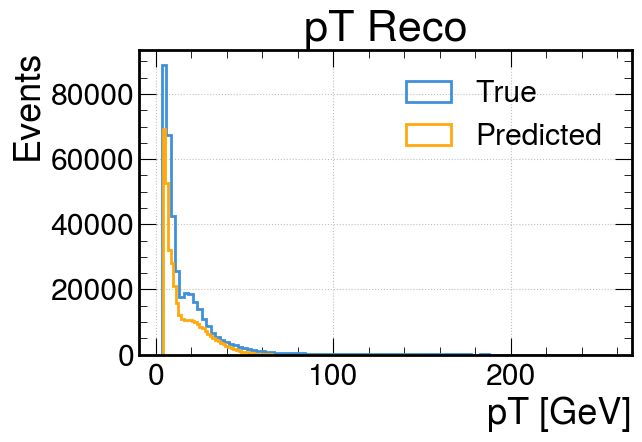

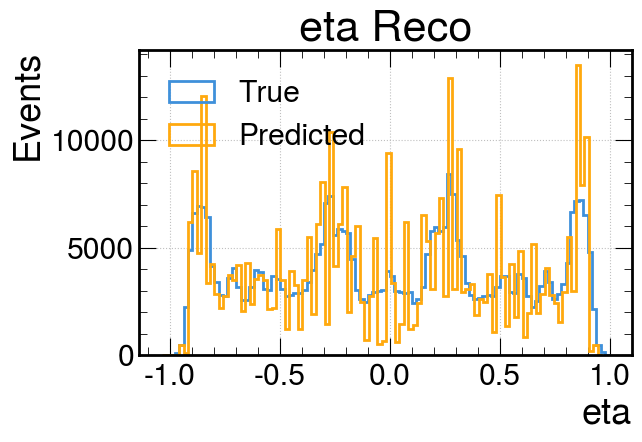

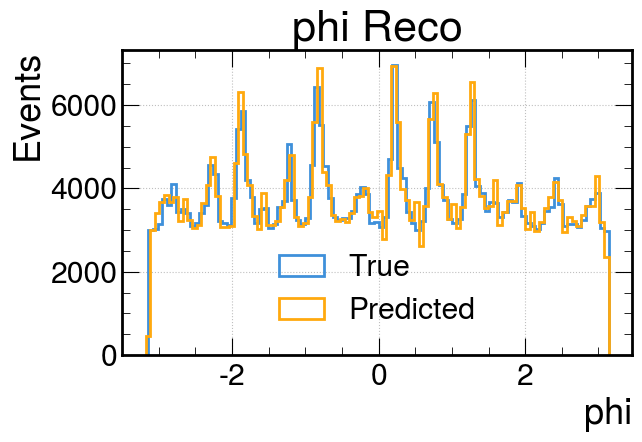

In [500]:
#plot the ptReco_true and ptReco_pred
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=100)
plt.hist(test_df["ptReco_true"], bins=100,  histtype="step", lw=2, label="True")
plt.hist(test_df["ptReco_pred"], bins=100,  histtype="step", lw=2, label="Predicted")
plt.xlabel("pT [GeV]")
plt.ylabel("Events")
plt.legend()
plt.title("pT Reco")
plt.grid()
plt.tight_layout()
plt.show()

#plot the etaReco_true and etaReco_pred
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=100)
plt.hist(test_df["etaReco_true"], bins=100,  histtype="step", lw=2, label="True")
plt.hist(test_df["etaReco_pred"], bins=100,  histtype="step", lw=2, label="Predicted")
plt.xlabel("eta")
plt.ylabel("Events")
plt.legend()
plt.title("eta Reco")
plt.grid()
plt.tight_layout()
plt.show()

#plot the phiReco_true and phiReco_pred
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=100)
plt.hist(test_df["phiReco_true"], bins=100,histtype="step", lw=2, label="True")
plt.hist(test_df["phiReco_pred"], bins=100, histtype="step", lw=2, label="Predicted")
plt.xlabel("phi")
plt.ylabel("Events")
plt.legend()
plt.title("phi Reco")
plt.grid()
plt.tight_layout()
plt.show()

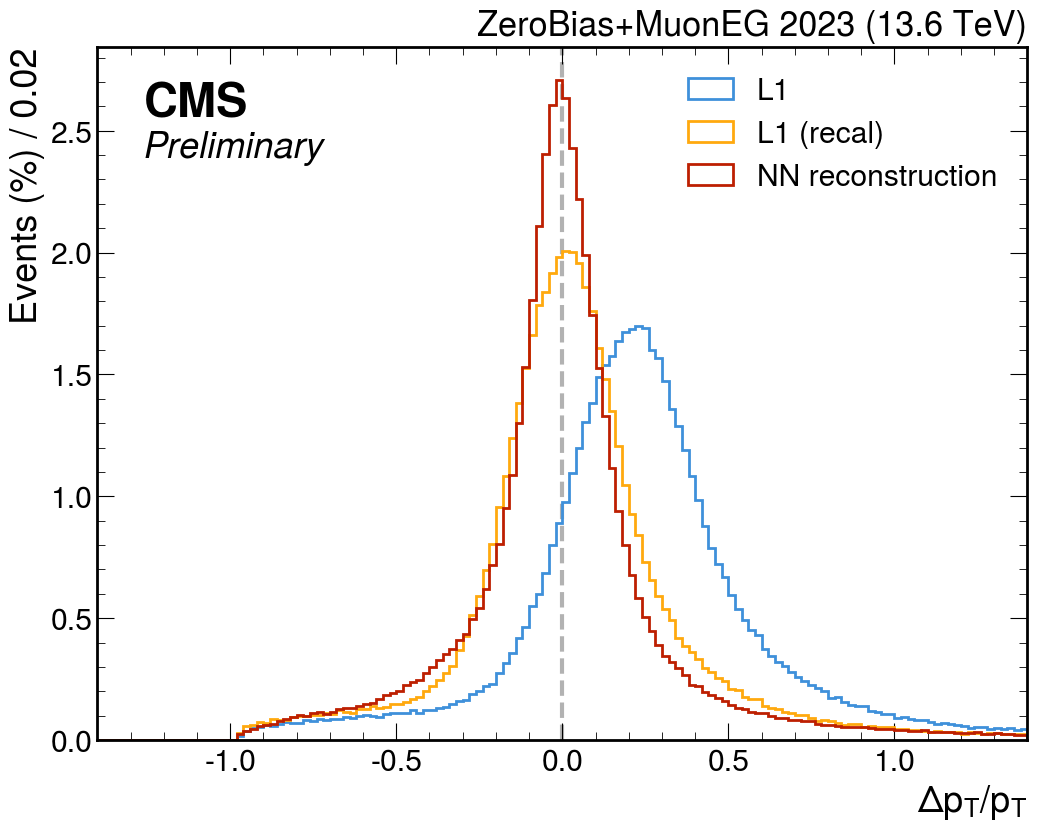

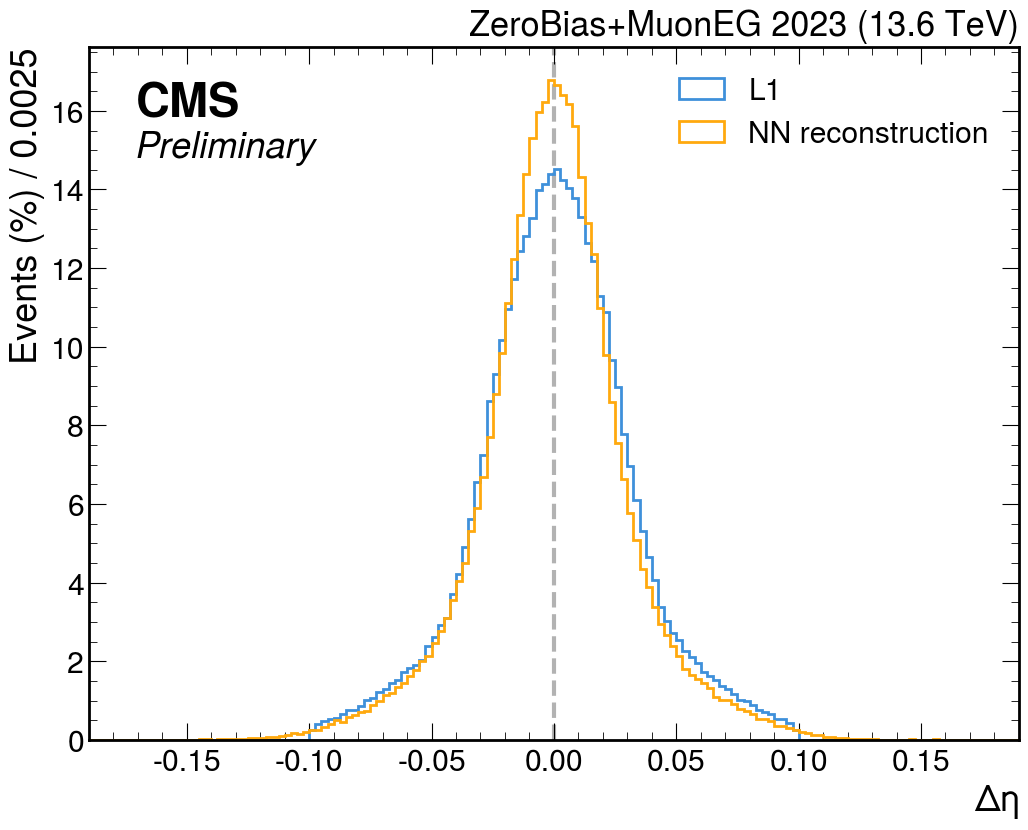

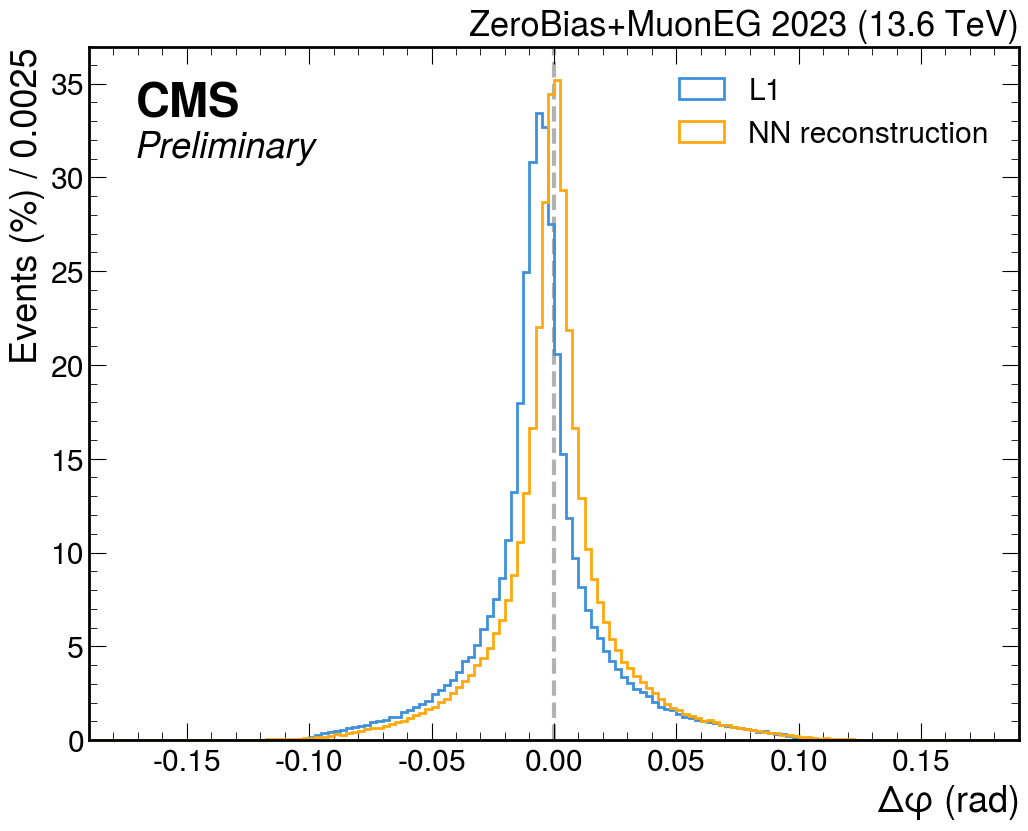

In [501]:
eta_res_pred = (test_df.etaReco_pred - test_df.etaReco_true) / test_df.etaReco_true

# if eta_res_pred < -0.5 then add 1 to shift the histogram to the right
# mask = np.where(eta_res_pred < -0.5, 1, 0)
# eta_res_pred = eta_res_pred + mask

# recompute the predicted eta
# test_df["etaReco_pred"] = test_df.etaReco_true * (1 + eta_res_pred)

pt_res_pred = (test_df.ptReco_pred - test_df.ptReco_true) / test_df.ptReco_true
pt_res_l1   = (test_df.ptL1  - test_df.ptReco_true) / test_df.ptReco_true
pt_res_rec_l1   = (test_df.ptL1/1.2  - test_df.ptReco_true) / test_df.ptReco_true

eta_res_pred = (test_df.etaReco_pred - test_df.etaReco_true) 
eta_res_l1   = (test_df.etaL1   - test_df.etaReco_true)

phi_res_pred = (test_df.phiReco_pred - test_df.phiReco_true)
phi_res_l1   = (test_df.phiL1   - test_df.phiReco_true)


rlabel = "ZeroBias+MuonEG 2023 (13.6 TeV)"

xmin = -1.4
xmax = 1.4
binw = 0.02

fig, ax = plt.subplots(1,1, figsize=(12,9), dpi = 100)
hep.cms.label("Preliminary", loc=2, data=True, year=2024, rlabel=rlabel)
plt.hist(pt_res_l1,     bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="L1")
plt.hist(pt_res_rec_l1, bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="L1 (recal)")
plt.hist(pt_res_pred,   bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="NN reconstruction")
ax.axvline(0, color="black", linestyle="--", linewidth=3, zorder=0, alpha=0.3)
plt.xlabel("$\Delta p_T / p_T$")
plt.ylabel(f"Events (%) / {binw}")
plt.xlim(xmin, xmax)
plt.legend()
fig.savefig(f"{PLOT_PATH}/pt_res_{learning_rate}_{batch_size}_{reg_strength}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")
plt.show()


xmin = -0.19
xmax = 0.19
binw = 0.0025

fig, ax = plt.subplots(1,1, figsize=(12,9), dpi = 100)
hep.cms.label("Preliminary", loc=2, data=True, year=2024, rlabel=rlabel)
plt.hist(eta_res_l1,     bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="L1")
plt.hist(eta_res_pred,   bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="NN reconstruction")
ax.axvline(0, color="black", linestyle="--", linewidth=3, zorder=0, alpha=0.3)
plt.xlabel("$\Delta \eta$")
plt.ylabel(f"Events (%) / {binw}")
plt.xlim(xmin, xmax)
plt.legend()
fig.savefig(f"{PLOT_PATH}/eta_res_{learning_rate}_{batch_size}_{reg_strength}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")
plt.show()


xmin = -0.19
xmax = 0.19
binw = 0.0025

fig, ax = plt.subplots(1,1, figsize=(12,9), dpi = 100)
hep.cms.label("Preliminary", loc=2, data=True, year=2024, rlabel=rlabel)
plt.hist(phi_res_l1,     bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="L1")
plt.hist(phi_res_pred,   bins=np.arange(xmin,xmax+binw,binw), histtype="step", lw=2, density=True, label="NN reconstruction")
ax.axvline(0, color="black", linestyle="--", linewidth=3, zorder=0, alpha=0.3)
plt.xlabel("$\Delta\\varphi$ (rad)")
plt.ylabel(f"Events (%) / {binw}")
plt.xlim(xmin, xmax)
plt.legend()
fig.savefig(f"{PLOT_PATH}/phi_res_{learning_rate}_{batch_size}_{reg_strength}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")
plt.show()

### pT resolution vs pT perd true 2D histogram

In [502]:
heights.shape

(100, 150)

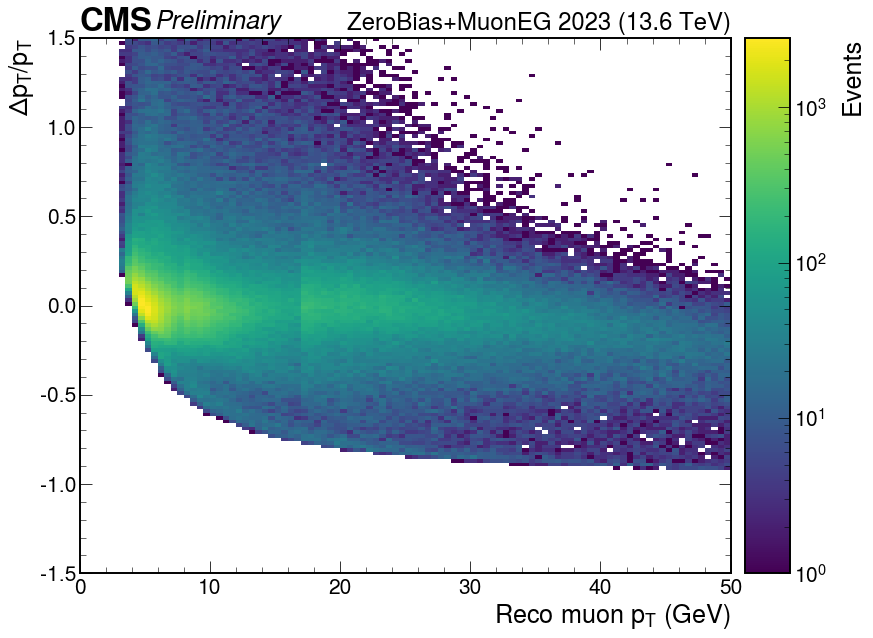

In [503]:
xmin = 0
xmax = 50
xbinw = 0.5
ymin = -1.5
ymax = 1.5
ybinw = 0.02

pt_res_pred = (test_df.ptReco_pred - test_df.ptReco_true) / test_df.ptReco_true
heights, binsx, binsy = np.histogram2d(test_df.ptReco_true, pt_res_pred, bins=(np.arange(xmin, xmax+xbinw, xbinw), np.arange(ymin, ymax+ybinw, ybinw)))

fig, ax = plt.subplots(figsize=(12,9), constrained_layout=True)
hep.cms.label(label="Preliminary", data=True, year=2023, rlabel=rlabel)

hep.hist2dplot(heights, binsx, binsy, ax=ax, cmap="viridis", flow=None, norm = mpl.colors.LogNorm())
cbar = ax.collections[0].colorbar
cbar.set_label("Events", labelpad=15) # , fontsize=36)
# cbar.ax.tick_params(labelsize=36)
# Adding labels and title
plt.xlabel("Reco muon $p_T$ (GeV)")
plt.ylabel("$\Delta p_T / p_T$")
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}pt_res_vs_pt_reco_true_zoom{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")
plt.show()

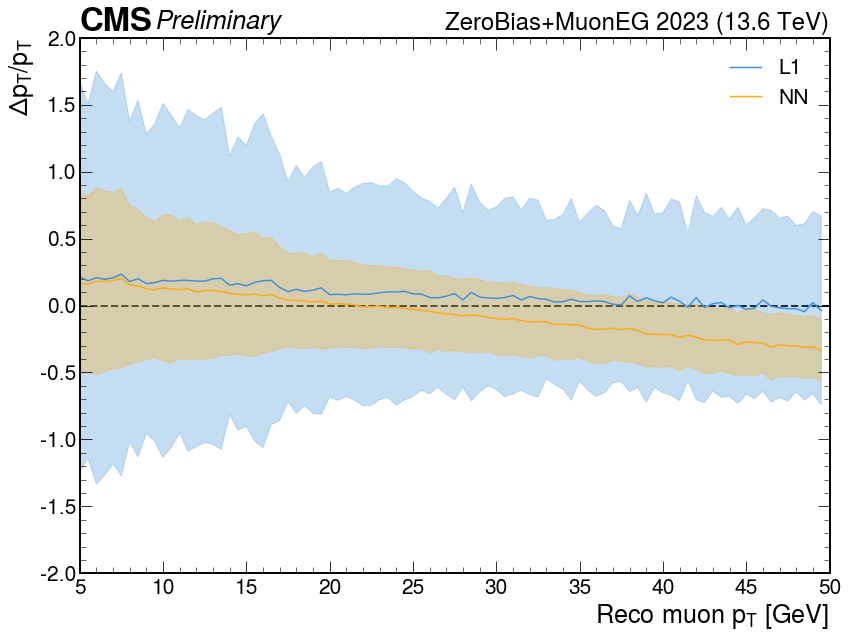

In [504]:
xmin = 0
xmax = 50
binw = 0.5

# Compute pT resolution
pt_res_pred = (test_df.ptReco_pred - test_df.ptReco_true) / test_df.ptReco_true
pt_res_l1   = (test_df.ptL1 / 1.2  - test_df.ptReco_true) / test_df.ptReco_true

# Define bins for pT reco true
pt_true_bins = np.arange(xmin, xmax+binw, binw)  # From 0 to 50 GeV with bin width 1 GeV

# Initialize arrays to store average pT resolution and standard deviation in each bin
avg_pt_res_pred = np.zeros(len(pt_true_bins) - 1)
std_pt_res_pred = np.zeros(len(pt_true_bins) - 1)
avg_pt_res_l1   = np.zeros(len(pt_true_bins) - 1)
std_pt_res_l1   = np.zeros(len(pt_true_bins) - 1)


# Loop through the bins to calculate average pT resolution and standard deviation
for i in range(len(pt_true_bins) - 1):
    lower_bound = pt_true_bins[i]
    upper_bound = pt_true_bins[i + 1]
    
    # Mask data points that fall within the current bin
    mask = (test_df.ptReco_true >= lower_bound) & (test_df.ptReco_true < upper_bound)
    
    # Compute the average pT resolution for the current bin
    avg_pt_res_pred[i] = np.mean(pt_res_pred[mask])
    avg_pt_res_l1[i]   = np.mean(pt_res_l1[mask])
    
    # Compute the standard deviation for the current bin
    std_pt_res_pred[i] = np.std(pt_res_pred[mask]) # / np.sqrt(len(pt_res_pred[mask]))
    std_pt_res_l1[i]   = np.std(pt_res_l1[mask])   # / np.sqrt(len(pt_res_l1[mask]))


# Create the profile plot
fig, ax = plt.subplots(figsize=(12,9), constrained_layout=True)
hep.cms.label(ax=ax, data=True, year=2023, label="Preliminary", rlabel=rlabel)
plt.plot(pt_true_bins[:-1], avg_pt_res_l1, "-", label="L1", color="C0")
plt.fill_between(pt_true_bins[:-1], avg_pt_res_l1 - std_pt_res_l1, avg_pt_res_l1 + std_pt_res_l1, alpha=0.3, color="C0")

plt.plot(pt_true_bins[:-1], avg_pt_res_pred, "-", label="NN", color="C1")
plt.fill_between(pt_true_bins[:-1], avg_pt_res_pred - std_pt_res_pred, avg_pt_res_pred + std_pt_res_pred, alpha=0.3, color="C1")

ax.axhline(0, color="black", linestyle="--", linewidth=2, zorder=0)

# Plotting the average pT resolution with error bars

# ax.errorbar(
#     x=pt_true_bins[:-1], 
#     y=avg_pt_res_l1, 
#     yerr=std_pt_res_l1, 
#     marker='o', 
#     linestyle="",
#     markersize=12,
#     elinewidth=3,
#     capthick=3,
#     capsize=5,
#     label="L1",
#     color=PALETTE[-1],
# )


# ax.errorbar(
#     x=pt_true_bins[:-1], 
#     y=avg_pt_res_pred, 
#     yerr=std_pt_res_pred, 
#     marker='o', 
#     linestyle="",
#     markersize=12,
#     elinewidth=3,
#     capthick=3,
#     capsize=5,
#     label="NN Prediction",
#     color=PALETTE[0],
# )


# ax.legend(fontsize=36, loc="upper right")


# Adding labels and title
plt.xlabel("Reco muon $p_T$ [GeV]")
plt.ylabel("$\Delta p_T / p_T$")

# ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}pt_res_vs_pt_reco_true_profile{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.xlim(5,xmax)
plt.ylim(-2,2)
plt.legend()
plt.show()


NameError: name 'train_classification_losses' is not defined

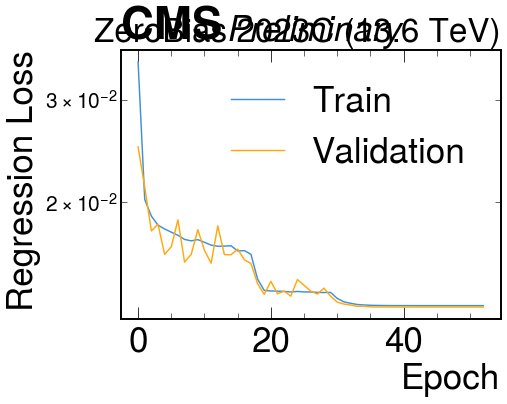

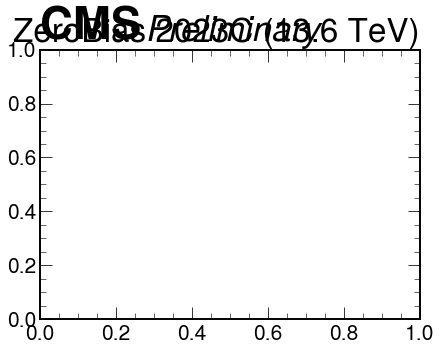

In [505]:
# plot losses
fig, ax = plt.subplots(figsize=FIGSIZE)

hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)

ax.plot(train_regression_losses, label="Train")
ax.plot(val_regression_losses, label="Validation")
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Regression Loss", fontsize=36)
ax.legend(fontsize=36)
ax.set_yscale("log")

ax.tick_params(axis='both', which='major', labelsize=36)


fig, ax = plt.subplots(figsize=FIGSIZE)

hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)

ax.plot(train_classification_losses, label="Train")
ax.plot(val_classification_losses, label="Validation")
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Classification Loss", fontsize=36)
ax.legend(fontsize=36)
ax.set_yscale("log")

ax.tick_params(axis='both', which='major', labelsize=36)


fig, ax = plt.subplots(figsize=FIGSIZE)

hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)

ax.plot(train_combined_losses, label="Train")
ax.plot(val_combined_losses, label="Validation")
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Combined Loss", fontsize=36)
ax.legend(fontsize=36)
ax.set_yscale("log")

ax.tick_params(axis='both', which='major', labelsize=36)


fig, ax = plt.subplots(figsize=FIGSIZE)
ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
ax.set_axisbelow(True)

hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)

ax.plot(learning_rates, lw=3)
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Learning Rate", fontsize=36)

ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}learning_rate{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.show()

fig, ax = plt.subplots(figsize=FIGSIZE)
ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
ax.set_axisbelow(True)

hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)

ax.plot(learning_rates, lw=3)
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Learning Rate", fontsize=36)

ax.set_yscale("log")

ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}log_learning_rate{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.show()

## Perform multiple trainings to compute average loss (TAKES A LOT OF TIME)

In [ ]:
N_ITER = 50

In [ ]:
@tf.function
def train_step(features, targets):
    with tf.GradientTape() as tape:
        regression_targets = targets[:, :-1]
        classification_targets = targets[:, -1]
        reg_outputs, class_outputs = model(features, training=True)
        regression_loss = regression_criterion(regression_targets, reg_outputs)
        classification_loss = classification_criterion(classification_targets, class_outputs)
        loss = regression_weight * regression_loss + classification_weight * classification_loss

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return regression_loss, classification_loss, loss

@tf.function
def val_step(features, targets):
    regression_targets = targets[:, :-1]
    classification_targets = targets[:, -1]
    reg_outputs, class_outputs = model(features, training=False)
    regression_loss = regression_criterion(regression_targets, reg_outputs)
    classification_loss = classification_criterion(classification_targets, class_outputs)
    loss = regression_weight * regression_loss + classification_weight * classification_loss
    return regression_loss, classification_loss, loss

In [ ]:
full_data_ = pd.DataFrame()

for file in os.listdir(FILE_PATH):
    if file.endswith(".csv"):
        full_data_ = pd.concat([full_data_, pd.read_csv(FILE_PATH + file)], ignore_index=True)
        
full_data_ = full_data_.iloc[:, :-1]

# drop rows with ptL1 == 4.5
full_data_ = full_data_[full_data_["ptL1"] != 4.5]

# drop rows with reco eta > 1 and < -1
full_data_ = full_data_[full_data_["etaExtRecoSt2"] < 1]
full_data_ = full_data_[full_data_["etaExtRecoSt2"] > -1]

# drop rows with ptL1 > 50
full_data_ = full_data_[full_data_["ptL1"] < 50]

# drop rows with ptReco > 50
full_data_ = full_data_[full_data_["ptReco"] < 50]


# mask_1 = (full_data_.etaL1 == 0) & (np.abs(full_data_.etaExtRecoSt2) == 0)
# mask_2 = (full_data_.etaL1 != 0)

# mask = mask_1 | mask_2

# full_data_ = full_data_[mask]

full_data_["ptRecoInverse"] = 1 / full_data_["ptReco"]

full_data = full_data_[stub_features + target_features + l1_features]

full_data["chargeReco"] = full_data["chargeReco"].apply(lambda x: 0 if x == -1 else 1)

In [ ]:
classification_criterion = losses.BinaryCrossentropy(from_logits=True)
regression_criterion     = losses.MeanAbsoluteError()

# lr scheduler
scale_factor = 0.5
patience = 5
min_loss_improvement = 0.1

classification_weight = 1
regression_weight     = 5

In [ ]:
train_regression_losses_all     = []
train_classification_losses_all = []
train_combined_losses_all       = []
val_regression_losses_all       = []
val_classification_losses_all   = []
val_combined_losses_all         = []

for i in range(N_ITER):
    
    # Hyperparameters
    input_size    = len(stub_features)
    architecture  = [input_size, 64, 32, 16, 8]
    output_size   = len(target_features)
    learning_rate = 1e-2
    num_epochs    = 300
    batch_size    = 2**10
    reg_strength  = 1e-3

    
    # Early stopping variables
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    patience = 10  # Number of epochs to wait before stopping
    early_stopping_threshold = 1e-5  # Minimum improvement in loss function to be considered as improvement


    train_val_data, test_data = train_test_split(full_data,      test_size=0.3, random_state=42)
    train_data, val_data      = train_test_split(train_val_data, test_size=0.1, random_state=42)

    # normalize the data
    for key in normalizations.keys():
        train_data[key] = train_data[key] / normalizations[key]
        val_data[key]   = val_data[key]   / normalizations[key]
        test_data[key]  = test_data[key]  / normalizations[key]
        
    
    train_dataset = tf.data.Dataset.from_tensor_slices((train_data[stub_features].values, train_data[target_features].values)).batch(batch_size).shuffle(buffer_size=len(train_data))
    val_dataset   = tf.data.Dataset.from_tensor_slices((val_data[stub_features].values, val_data[target_features].values)).batch(batch_size)
    test_dataset  = tf.data.Dataset.from_tensor_slices((test_data[stub_features].values, test_data[target_features].values)).batch(batch_size)


    # Create the model
    model = MultiTaskNN(architecture, reg_strength=reg_strength)

    # Build the model with the batch input shape
    bs = None  # None allows for variable batch size
    model.build((bs, input_size))

    optimizer = optimizers.Adam(learning_rate=learning_rate)
    scheduler = CustomLRScheduler(
        optimizer, 
        factor=scale_factor, 
        patience=patience, 
        min_improvement=min_loss_improvement, 
        verbose=True
    )


    train_regression_losses     = []
    train_classification_losses = []
    train_combined_losses       = []
    val_regression_losses       = []
    val_classification_losses   = []
    val_combined_losses         = []

    learning_rates = []
    
    @tf.function
    def train_step(features, targets):
        with tf.GradientTape() as tape:
            regression_targets = targets[:, :-1]
            classification_targets = targets[:, -1]
            reg_outputs, class_outputs = model(features, training=True)
            regression_loss = regression_criterion(regression_targets, reg_outputs)
            classification_loss = classification_criterion(classification_targets, class_outputs)
            loss = regression_weight * regression_loss + classification_weight * classification_loss

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        return regression_loss, classification_loss, loss

    @tf.function
    def val_step(features, targets):
        regression_targets = targets[:, :-1]
        classification_targets = targets[:, -1]
        reg_outputs, class_outputs = model(features, training=False)
        regression_loss = regression_criterion(regression_targets, reg_outputs)
        classification_loss = classification_criterion(classification_targets, class_outputs)
        loss = regression_weight * regression_loss + classification_weight * classification_loss
        return regression_loss, classification_loss, loss


    # Training loop
    for epoch in range(num_epochs):
        # Training
        running_loss                = 0.0
        running_regression_loss     = 0.0
        running_classification_loss = 0.0
        
        
        for features, targets in train_dataset:
            
            regression_loss, classification_loss, loss = train_step(features, targets)
            
            running_loss                += loss.numpy()
            running_regression_loss     += regression_loss.numpy()
            running_classification_loss += classification_loss.numpy()


            
        # Note: Remember to adjust if not using batches of equal sizes
        train_loss                = running_loss                / len(train_dataset)
        train_regression_loss     = running_regression_loss     / len(train_dataset)
        train_classification_loss = running_classification_loss / len(train_dataset)

        train_regression_losses.append(train_regression_loss)
        train_classification_losses.append(train_classification_loss)
        train_combined_losses.append(train_loss)

        # Validation
        running_loss                = 0.0
        running_regression_loss     = 0.0
        running_classification_loss = 0.0
        
        for features, targets in val_dataset:
            
            regression_loss, classification_loss, loss = val_step(features, targets)
            
            running_loss                += loss.numpy()
            running_regression_loss     += regression_loss.numpy()
            running_classification_loss += classification_loss.numpy()
        
        avg_val_loss                = running_loss                / len(val_dataset)
        avg_val_regression_loss     = running_regression_loss     / len(val_dataset)
        avg_val_classification_loss = running_classification_loss / len(val_dataset)
            
        val_regression_losses.append(avg_val_regression_loss)
        val_classification_losses.append(avg_val_classification_loss)
        val_combined_losses.append(avg_val_loss)
        
        
        current_lr = optimizer.lr.numpy()
        learning_rates.append(current_lr)
        
        
        
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        print(f"Learning rate: {current_lr:.2e}")
        print(f"Train Losses - Regression: {train_regression_losses[-1]:.4f}, Classification: {train_classification_losses[-1]:.4f}, Combined: {train_combined_losses[-1]:.4f}")
        print(f"Validation Losses - Regression: {val_regression_losses[-1]:.4f}, Classification: {val_classification_losses[-1]:.4f}, Combined: {val_combined_losses[-1]:.4f}")
        print("-------------")
        
        
        scheduler.on_epoch_end(epoch, {"val_loss": avg_val_loss})

        

        # Check for early stopping based on the new criterion
        if avg_val_loss < (1 - early_stopping_threshold) * best_val_loss:  # 0.001 corresponds to 0.1%
            epochs_without_improvement = 0
            best_val_loss = min(best_val_loss, avg_val_loss)
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break
        
    train_regression_losses_all.append(train_regression_losses)
    train_classification_losses_all.append(train_classification_losses)
    train_combined_losses_all.append(train_combined_losses)
    val_regression_losses_all.append(val_regression_losses)
    val_classification_losses_all.append(val_classification_losses)
    val_combined_losses_all.append(val_combined_losses)
    
    del model
    del optimizer
    del scheduler
    del train_dataset
    del val_dataset
    del test_dataset
    del train_data
    del val_data
    del test_data
    del train_val_data

Epoch [1/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.1081, Classification: 0.1282, Combined: 0.6685
Validation Losses - Regression: 0.0584, Classification: 0.0825, Combined: 0.3743
-------------
Epoch [2/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.0399, Classification: 0.0807, Combined: 0.2800
Validation Losses - Regression: 0.0396, Classification: 0.0756, Combined: 0.2735
-------------
Epoch [3/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.0305, Classification: 0.0767, Combined: 0.2290
Validation Losses - Regression: 0.0301, Classification: 0.0725, Combined: 0.2228
-------------
Epoch [4/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.0256, Classification: 0.0753, Combined: 0.2033
Validation Losses - Regression: 0.0229, Classification: 0.0713, Combined: 0.1856
-------------
Epoch [5/300]
Learning rate: 1.00e-02
Train Losses - Regression: 0.0234, Classification: 0.0734, Combined: 0.1903
Validation Losses - Regression: 0.0204, Classifica

KeyboardInterrupt: 

In [ ]:
# compute the mean and std of the losses for each epoch
# the lists in the lists are of different lengths, so we need to pad them with the last value
# then we can compute the mean and std

train_regression_losses_all      = [x + [x[-1]] * (max(map(len, train_regression_losses_all)) - len(x)) for x in train_regression_losses_all]
train_classification_losses_all  = [x + [x[-1]] * (max(map(len, train_classification_losses_all)) - len(x)) for x in train_classification_losses_all]
train_combined_losses_all        = [x + [x[-1]] * (max(map(len, train_combined_losses_all)) - len(x)) for x in train_combined_losses_all]

val_regression_losses_all        = [x + [x[-1]] * (max(map(len, val_regression_losses_all)) - len(x)) for x in val_regression_losses_all]
val_classification_losses_all    = [x + [x[-1]] * (max(map(len, val_classification_losses_all)) - len(x)) for x in val_classification_losses_all]
val_combined_losses_all          = [x + [x[-1]] * (max(map(len, val_combined_losses_all)) - len(x)) for x in val_combined_losses_all]

train_regression_losses_mean     = np.mean(np.array(train_regression_losses_all), axis=0)[1:]
train_regression_losses_std      = np.std(np.array(train_regression_losses_all), axis=0)[1:]
train_classification_losses_mean = np.mean(np.array(train_classification_losses_all), axis=0)[1:]
train_classification_losses_std  = np.std(np.array(train_classification_losses_all), axis=0)[1:]
train_combined_losses_mean       = np.mean(np.array(train_combined_losses_all), axis=0)[1:]
train_combined_losses_std        = np.std(np.array(train_combined_losses_all), axis=0)[1:]

val_regression_losses_mean       = np.mean(np.array(val_regression_losses_all), axis=0)[1:]
val_regression_losses_std        = np.std(np.array(val_regression_losses_all), axis=0)[1:]
val_classification_losses_mean   = np.mean(np.array(val_classification_losses_all), axis=0)[1:]
val_classification_losses_std    = np.std(np.array(val_classification_losses_all), axis=0)[1:]
val_combined_losses_mean         = np.mean(np.array(val_combined_losses_all), axis=0)[1:]
val_combined_losses_std          = np.std(np.array(val_combined_losses_all), axis=0)[1:]

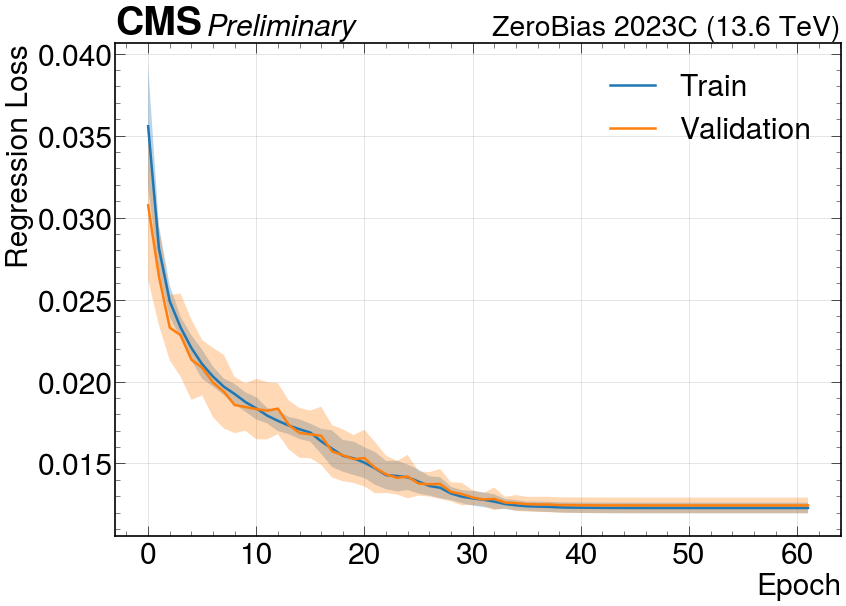

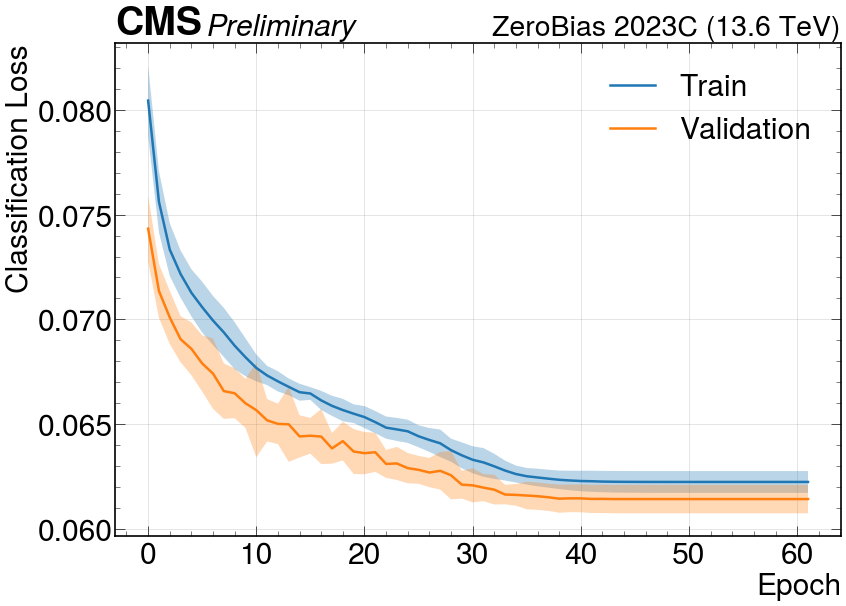

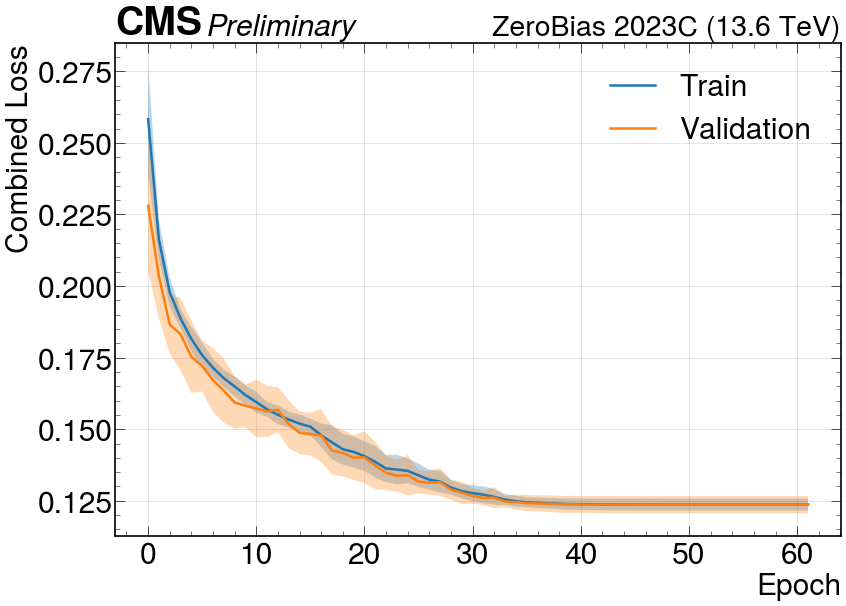

In [ ]:


# REGRESSION LOSS
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
ax.set_axisbelow(True)
hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)
ax.plot(train_regression_losses_mean, label="Train", color=PALETTE[0], linewidth=3)
ax.fill_between(np.arange(len(train_regression_losses_mean)), train_regression_losses_mean - train_regression_losses_std, train_regression_losses_mean + train_regression_losses_std, alpha=0.3)
ax.plot(val_regression_losses_mean, label="Validation", color=PALETTE[-1], linewidth=3)
ax.fill_between(np.arange(len(val_regression_losses_mean)), val_regression_losses_mean - val_regression_losses_std, val_regression_losses_mean + val_regression_losses_std, alpha=0.3)
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Regression Loss", fontsize=36)
ax.legend(fontsize=36)
# ax.set_yscale("log")
ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}regression_loss_{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.show()

# CLASSIFICATION LOSS
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
ax.set_axisbelow(True)
hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)
ax.plot(train_classification_losses_mean, label="Train", color=PALETTE[0], linewidth=3)
ax.fill_between(np.arange(len(train_classification_losses_mean)), train_classification_losses_mean - train_classification_losses_std, train_classification_losses_mean + train_classification_losses_std, alpha=0.3)
ax.plot(val_classification_losses_mean, label="Validation", color=PALETTE[-1], linewidth=3)
ax.fill_between(np.arange(len(val_classification_losses_mean)), val_classification_losses_mean - val_classification_losses_std, val_classification_losses_mean + val_classification_losses_std, alpha=0.3)
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Classification Loss", fontsize=36)
ax.legend(fontsize=36)
# ax.set_yscale("log")
ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}classification_loss_{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.show()

# COMBINED LOSS
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
ax.grid(which="major", axis="both", alpha=0.3, color="gray", linestyle="-")
ax.set_axisbelow(True)
hep.cms.label(
    ax     = ax,
    data   = True,
    label  = "Preliminary",
    rlabel = "ZeroBias 2023C (13.6 TeV)",
    fontsize = 36,
)
ax.plot(train_combined_losses_mean, label="Train", color=PALETTE[0], linewidth=3)
ax.fill_between(np.arange(len(train_combined_losses_mean)), train_combined_losses_mean - train_combined_losses_std, train_combined_losses_mean + train_combined_losses_std, alpha=0.3)
ax.plot(val_combined_losses_mean, label="Validation", color=PALETTE[-1], linewidth=3)
ax.fill_between(np.arange(len(val_combined_losses_mean)), val_combined_losses_mean - val_combined_losses_std, val_combined_losses_mean + val_combined_losses_std, alpha=0.3)
ax.set_xlabel("Epoch", fontsize=36)
ax.set_ylabel("Combined Loss", fontsize=36)
ax.legend(fontsize=36)
# ax.set_yscale("log")
ax.tick_params(axis='both', which='major', labelsize=36)

if PLOT_FLAG:
    fig.savefig(f"{PLOT_PATH}combined_loss_{learning_rate}_{batch_size}_{reg_strength}_{regression_weight}_{min_loss_improvement}_{early_stopping_threshold}.pdf", dpi=300, facecolor="white")

plt.show()